Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 1s 1s/step
-0.3857738111855532
Probabilities 0.7344186983874199 0.2655813016125801


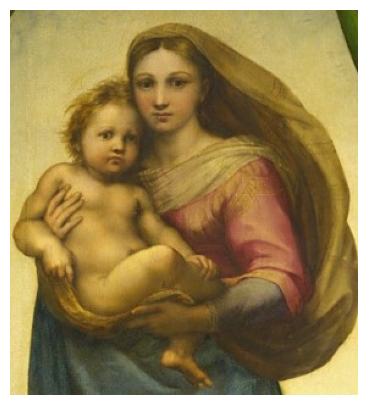

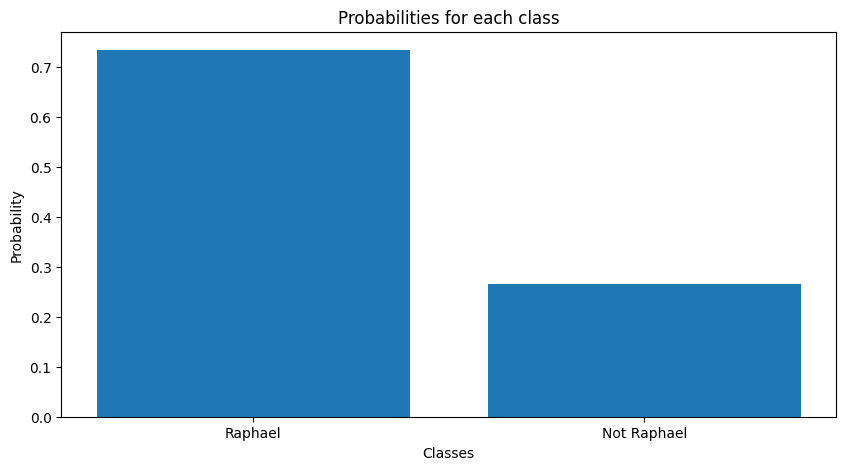

1/1 [==============================] - 1s 1s/step
0.0
Probabilities 0.8747389990062993 0.12526100099370074


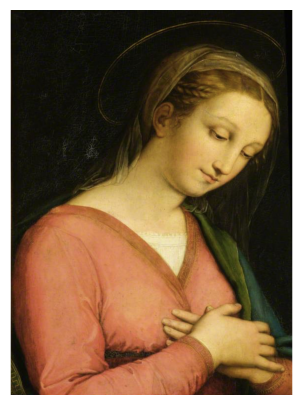

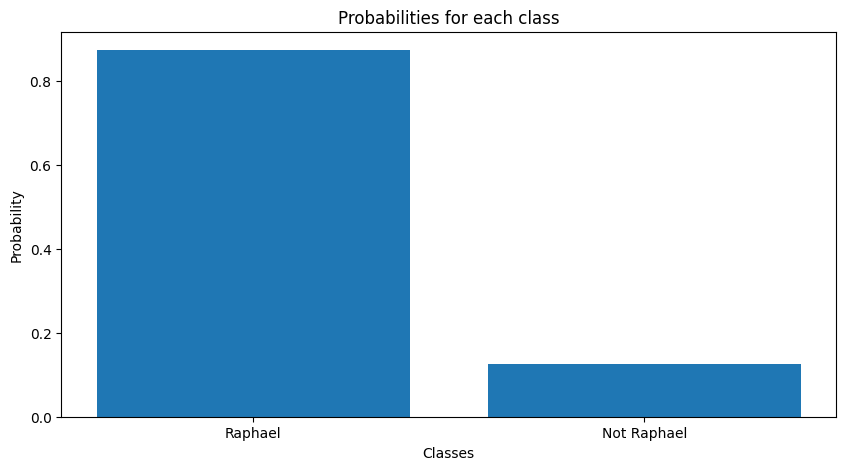

1/1 [==============================] - 1s 1s/step
-0.99
Probabilities 0.19710994947978167 0.8028900505202183


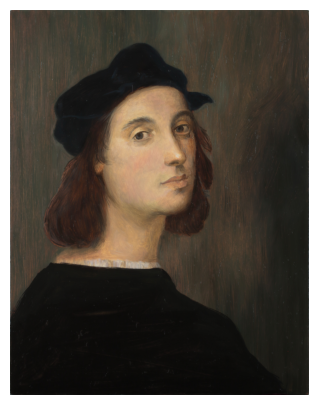

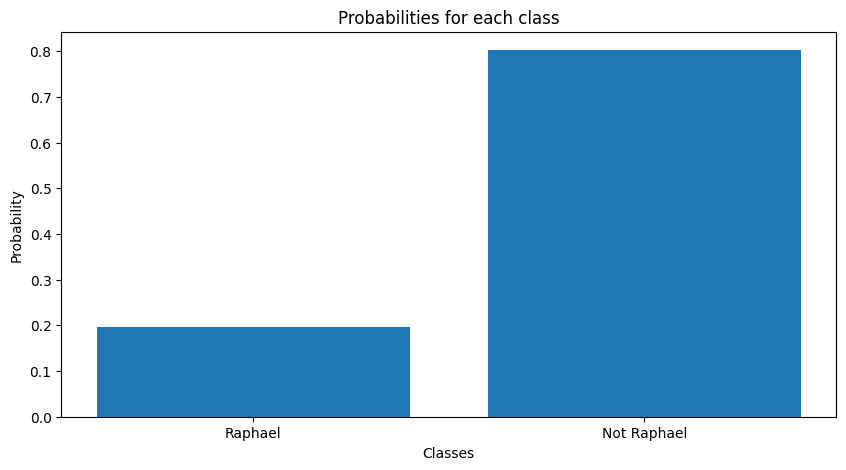

1/1 [==============================] - 1s 1s/step
0.0
Probabilities 0.8525214143119579 0.14747858568804206


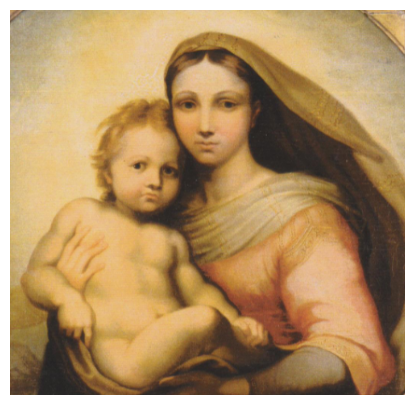

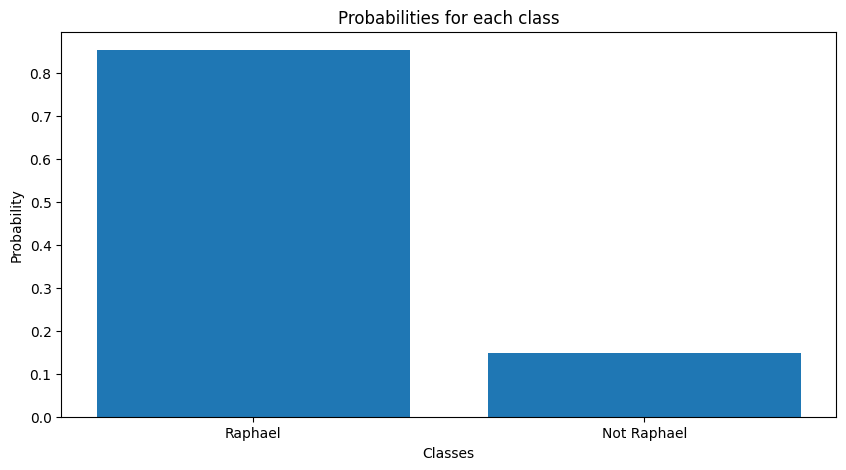

In [5]:
import os
import cv2
import numpy as np
import glob
import joblib
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import math


from google.colab import drive
drive.mount('/content/drive')

def scale_inverse_log(x, x_min, x_max, y_min, y_max):
    # Check input boundaries
    if x < x_min or x > x_max:
        return "Input x must be within the range [x_min, x_max]"

    # Calculate inverse log of x
    inv_log_x = -1 / math.log(x + 1)

    # Calculate inverse log of x_min and x_max
    inv_log_x_min = -1 / math.log(x_min + 1)
    inv_log_x_max = -1 / math.log(x_max + 1)

    # Scale the inverse logarithmic value to the target range [y_min, y_max]
    y = y_min + (inv_log_x - inv_log_x_min) * (y_max - y_min) / (inv_log_x_max - inv_log_x_min)

    return y


# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

def extract_features(img_path, model):
    img = load_and_preprocess_image(img_path)
    features = model.predict(img)
    return features.reshape(-1)

def visualize_probabilities(categories, probabilities):
    # Load image
    img = Image.open(test_image_path)

    # Create subplots
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot image on first subplot
    ax1.imshow(img)
    ax1.axis('off')
    plt.show()

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(categories, probabilities)
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title('Probabilities for each class')
    plt.show()

# Function to calculate edge features using Canny edge detector
def calculate_canny_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return np.std(edges)

# Function to calculate edge features using Sobel operator
def calculate_sobel_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    return np.std(sobelx), np.std(sobely)

# Function to calculate edge features using Laplacian operator
def calculate_laplacian_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return np.std(laplacian)

# Function to calculate edge features using Scharr operator
def calculate_scharr_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    return np.std(scharrx), np.std(scharry)

# Function to calculate all edge features
def calculate_features(img):
    canny_edges = calculate_canny_edges(img)
    sobel_edges_x, sobel_edges_y = calculate_sobel_edges(img)
    laplacian_edges = calculate_laplacian_edges(img)
    scharr_edges_x, scharr_edges_y = calculate_scharr_edges(img)
    return np.array([canny_edges, sobel_edges_x, sobel_edges_y, laplacian_edges, scharr_edges_x, scharr_edges_y])

def compare_image_with_dataset(test_image_path, image_dir, categories):


    # Load test image
    test_image = cv2.imread(test_image_path)


    # Load the final model
    svm_final = joblib.load(Model_Path)

    # Load the saved model
    model = load_model(ResNet_Path)

    # Extract features from the test image
    test_image_features = extract_features(test_image_path, model)

    # Use the loaded model to predict the category of the test image
    predicted_category = svm_final.predict([test_image_features])[0]

    # Calculate probabilities for each category
    probabilities = svm_final.predict_proba([test_image_features])[0]

    categories = ['Raphael', 'Not Raphael']

    # Calculate features of test image
    test_features = calculate_features(test_image)

    # Normalize test features to get weights
    weights = test_features / np.sum(test_features)

    # Load all images in directory
    formats = ('*.jpg', '*.png', '*.bmp')  # Add or remove formats as needed
    image_paths = []
    for fmt in formats:
        image_paths.extend(glob.glob(f"{image_dir}/{fmt}"))

    # Calculate the total feature values and the count of images
    total_features = np.zeros_like(test_features)
    image_count = 0

    for image_path in image_paths:
        # Load image
        image = cv2.imread(image_path)

        # Calculate features of image
        image_features = calculate_features(image)

        # Add to total and increment count (multiply by weights here)
        total_features += image_features * weights
        image_count += 1

    # Calculate the weighted average feature values
    average_features = total_features / image_count if image_count else np.zeros_like(test_features)

    # Compare average features with test image
    difference = np.abs(test_features - average_features)

    # Sum of differences
    sum_diff = np.sum(difference)

    max_diff = np.max(difference)
    min_diff = np.min(difference)
    mean_diff = np.mean(difference)
    edge_threshold = (mean_diff - min_diff) / mean_diff



#penalise for edge information (these values can be found by experimentation)
    if mean_diff < 50:
        mean_diff = 400
        probabilities[0] = probabilities[0] - 0.3

    if mean_diff > 400:
        mean_diff = 400
        probabilities[0] = probabilities[0] - 0.3

    if mean_diff < 150:
        mean_diff = 150

    scale_ = scale_inverse_log(mean_diff, x_min=150, x_max=400, y_min=0.0, y_max=-0.99)
    print (scale_)

    threshold = 0.95* probabilities[0] + 0.05*scale_
    ##print("Threshold:", threshold)

    probabilities[0] = threshold
    probabilities[1] = 1 - threshold
    print("Probabilities", probabilities[0], probabilities[1])
    visualize_probabilities(categories, probabilities)




#Load the trained model and Resnet base model
ResNet_Path = "/content/drive/MyDrive/Colab Notebooks/RaphaelHeritageSciencePaper/models/resnet50_model.h5"
Model_Path = "/content/drive/MyDrive/Colab Notebooks/RaphaelHeritageSciencePaper/models/28_09_2023_svm_final_model.pkl"


# Define categories
categories = ['Raphael', 'Not Raphael']

# Define directory containing test images and training images (for edge feature extraction)
test_image_dir = "/content/drive/MyDrive/Colab Notebooks/RaphaelHeritageSciencePaper/Tests"
image_dir = "/content/drive/MyDrive/Colab Notebooks/RaphaelHeritageSciencePaper/data/Raphael"

# Get all test images in directory
formats = ('*.jpg', '*.png', '*.bmp')
test_image_paths = []
for fmt in formats:
    test_image_paths.extend(glob.glob(f"{test_image_dir}/{fmt}"))

# Loop through each test image and compare with dataset
for test_image_path in test_image_paths:
    compare_image_with_dataset(test_image_path, image_dir, categories)
